# Arcsinh taylor series (slow, faster, fast!)

I write a couple versions of taylor series of arcsinh(x) with different realisation.

## Slow

First realization based on taylor seies from https://functions.wolfram.com/ElementaryFunctions/ArcSinh/06/01/03/01/

Radius of convergence = 1

In [3]:
import numpy as np
import math

def StirlingS1(n, k):   #Stirling numbers of the first kind
    if(n==0 and k == 0): return 1
    if(n==0 or k == 0): return 0
    return StirlingS1(n-1, k-1) - (n-1)*StirlingS1(n-1, k)


def Pochhammer(a, n):   #https://functions.wolfram.com/GammaBetaErf/Pochhammer/06/01/01/01/02/0001/
    Sum = 0.0
    k = 0
    while(k<=n):
        if((n+k) % 2 == 0): Sum += StirlingS1(n,k)*math.pow(a, k)
        else:               Sum -= StirlingS1(n,k)*math.pow(a, k)
        k+=1
    return Sum


def Arcsinh(x):     #taylor serie for real numbers |x| <= 1
    k = 0
    Sum = 0.0
    while(k < 14):
        if(k % 2 == 0): Sum += math.pow(x, 1+2*k) * Pochhammer(0.5, k) / (1+2*k) / math.factorial(k)
        else:           Sum -= math.pow(x, 1+2*k) * Pochhammer(0.5, k) / (1+2*k) / math.factorial(k)
        k+=1
    return Sum


print(Arcsinh(0.5)-np.arcsinh(0.5))
%timeit Arcsinh(0.5)

-7.830569526134923e-12
40.9 ms ± 1.47 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


This is pretty slow, so we need to use another formula.

## Faster


$arcsinh(x) = x - \frac{1}{2}\frac{x^3}{3}+\frac{1*3}{2*4}\frac{x^5}{5}+\frac{1*3*5}{2*4*6}\frac{x^7}{7} + O(x^9)$

Radius of convergence = 1

In [4]:
import numpy

def arcsinh(x, count):
        xx = x*x
        D = 1
        tail = 0
        for n in range(count):
            tail += xx**n * D/(2*n+1)
            D *= -(2*n+1)/(2*n+2)
        return tail*x


print(arcsinh(0.5, 20)-numpy.arcsinh(0.5))
%timeit arcsinh(0.5, 20)

-1.1102230246251565e-15
8.04 µs ± 471 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


This realisation really better and faster!

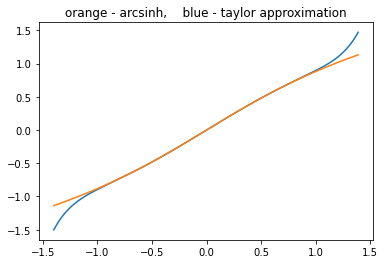

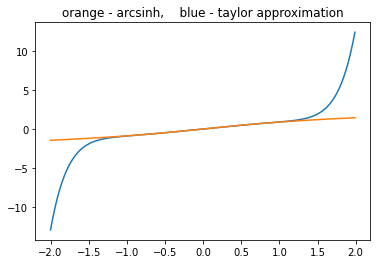

In [5]:
import matplotlib.pyplot as plt


x = np.arange(-1.4, 1.4, 0.01)
y0 = arcsinh(x, 5)
y1 = np.arcsinh(x)
plt.plot(x, y0)
plt.plot(x, y1)
plt.title("orange - arcsinh,    blue - taylor approximation")
plt.show()

X = np.arange(-2, 2, 0.01)
Y0 = arcsinh(X, 5)
Y1 = np.arcsinh(X)
plt.plot(X, Y0)
plt.plot(X, Y1)
plt.title("orange - arcsinh,    blue - taylor approximation")
plt.show()

As we can see, series approximation is correct when |x| < 1
But we can better!

Let's find taylor series around arbitrary n

$arcsinh(x) = arcsinh(n) + \frac{x-n}{(1+n^2)^{0.5}} - \frac{n*(x-n)^2}{2(1+n^2)^{1.5}} + \frac{(2*n^2-1)*(x-n)^3}{6(1+n^2)^{2.5}}- \frac{n*(2*n^2-3)*(x-n)^4}{8(1+n^2)^{3.5}}+ \frac{(8*n^4-24*n^2+3)*(x-n)^5}{40(1+n^2)^{4.5}} + O(x^6)$

In [6]:
import numpy as np
import math


def arcsinh(x, n):
    if(x < 0): return arcsinh(-x, abs(n))  #arcsinh is odd function, so we can do that
    nn = n*n
    d = (x-n)/(nn+1)
    D = (x-n)
    tail = D
    D*=d
    tail -= n*D/2
    D*=d
    tail += (2*nn-1)*D/6
    D*=d
    tail -= n*(2*nn-3)*D/8
    D*=d
    tail += (8*(nn-3)*nn+3)*D/40
    if(n<=0.01): return tail/math.sqrt(nn+1)
    return arcsinh(n,n-0.5)+tail/math.sqrt(nn+1)

print (arcsinh(7.5,8)-np.arcsinh(7.5))
%timeit arcsinh(7.5,8)

0.0002998498604465105
24.6 µs ± 3.21 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


This is x1000 times faster, then my first one, but less accurate.
But can we do faster and more accurate?

## FAST!

In [7]:
import numpy as np
import math
import numba
from numba import njit

@njit
def chi(n):   #optional correction for count of steps in calculation of arcsinh_at()
    if (n < 5): return n - 0.25
    return n - 0.5



@njit
def arcsinh(x):
    if(x < 0): return -arcsinh(-x)
    else: return arcsinh_at(x, chi(x))

@njit
def arcsinh_at0(x):
        xx = x*x
        D = 1
        tail = 0
        
        for n in range(8):
                tail += xx**n * D/(2*n+1)
                D *= -(2*n+1)/(2*n+2)
        
        if(x > 0.5):
            for n in range(8, 11):
                tail += xx**n * D/(2*n+1)
                D *= -(2*n+1)/(2*n+2)
        return tail*x

@njit
def arcsinh_at(x, n):
    if(x < 0.9):
        return arcsinh_at0(x)
    nn = n*n
    d = (x-n)/(nn+1)
    D = (x-n)
    tail = D
    D*=d
    tail -= n*D/2
    D*=d
    tail += (2*nn-1)*D/6
    D*=d
    tail -= n*(2*nn-3)*D/8
    D*=d
    tail += (8*(nn-3)*nn+3)*D/40
    if(n<=0.01): return tail/(nn+1)**0.5
    return arcsinh_at(n,chi(n))+tail/(nn+1)**0.5

x = 20
print (arcsinh(x)-np.arcsinh(x))
%timeit arcsinh(x)

2.0875454009861016e-06
950 ns ± 173 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [8]:
import numpy as np
%timeit np.arcsinh(20)

1.13 µs ± 61.3 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Well, we get fast and accurate code code for arcsinh(x) with taylor series and recursion.
The last one even **faster than numpy realization of this function**!
Also, we increase accurate accuracy.

In that algorithm we used tweaks with decreasing of multiplication. This really help in calculations.

But *njit* package even more usefull for that.

*And several plots for sweet!*

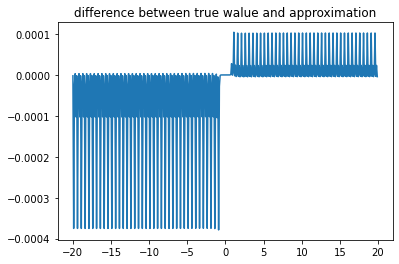

In [9]:
import matplotlib.pyplot as plt


X = np.arange(-20, 20, 0.1)
Y = []
for x in X:
    Y.append(arcsinh(x) - np.arcsinh(x))
plt.plot(X, Y)
plt.title("difference between true walue and approximation")
plt.show()

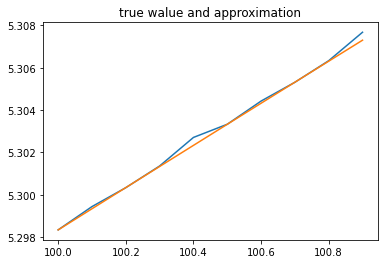

In [10]:
import matplotlib.pyplot as plt


X = np.arange(100, 101, 0.1)
Y = []
for x in X:
    Y.append(arcsinh(x))
plt.plot(X, Y)
plt.plot(X, np.arcsinh(X))
plt.title("true walue and approximation")
plt.show()